Size of:
- Training-set:		37882
- Validation-set:	6262


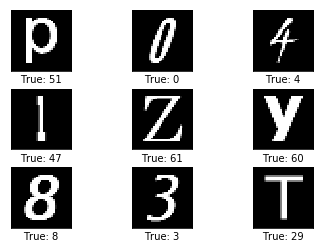

In [17]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 24 00:21:41 2018

@author: aditya.sharma
"""

# In[1]:


import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import random

tf.__version__


# ### *Step 1:* Loading data
# The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

# In[2]:


class DataSet(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._index_in_epoch = 0
        self._epochs_done = 0
        self._cls = cls

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            # After each epoch we update this
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]
    

def load_data(input_path, dataset_type, image_size):
    images = []
    labels = []
    img_names = []
    cls = []
    
    data_path = os.path.join(input_path, str(dataset_type+'-set'))
    label_path = os.path.join(input_path, str(dataset_type+'.txt'))
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()
        random.shuffle(lines)
        for line in lines:
            filename, index = line.split(' ')
            label = np.zeros(62)
            label[int(index)] = 1.0
            labels.append(label)
            
            
            img_names.append(filename)
            image_file_path = os.path.join(data_path, filename)
            image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            image = np.reshape(image, image_size*image_size)
            images.append(image)
            cls.append(int(index))
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)

            
    return DataSet(images, labels, img_names, cls)
            

def read_train_sets(input_path, image_size):
    class DataSets(object):
        pass
    data_sets = DataSets()
    
    data_sets.train = load_data(input_path, 'train', image_size)
    data_sets.validation = load_data(input_path, 'vali', image_size)
    
    return data_sets
    
 
# In[3]: load data

input_path = '../Input/'
validation_size = 0.2
img_size = 32
num_channels = 1
num_classes = 62
batch_size = 32




data = read_train_sets(input_path, img_size)

# The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and validation-sets in this tutorial.

# In[3]:


print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


# The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the validation-set, so we calculate it now.

# ### Helper-function for plotting images - MNIST

# In[4]:


def plot_images(images, cls_true, img_shape=None, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_size,img_size)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


images = data.validation.images[0:9]
cls_true = data.validation.cls[0:9]

plot_images(images=images, cls_true=cls_true)


img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 62
train_batch_size = 64

In [21]:
data.train

In [22]:
# Exp 3 : 10000 iterations val accuracy:22.5
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.
stride_size1 = 1

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 36 of these filters.
stride_size2 = 1

# Convolutional Layer 3.
filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 36 of these filters.
stride_size3 = 1

# Convolutional Layer 2.
filter_size4 = 5          # Convolution filters are 5 x 5 pixels.
num_filters4 = 128         # There are 36 of these filters.
stride_size4 = 1


# Fully-connected layer.
fc_size = 500             # Number of neurons in fully-connected layer.
dropout = 0.1

regularization_coefficient = 0.01


def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


# #### Function for creating a new Convolutional Layer

# This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.
# 
# It is assumed that the input is a 4-dim tensor with the following dimensions:
# 
# 1. Image number.
# 2. Y-axis of each image.
# 3. X-axis of each image.
# 4. Channels of each image.
# 
# Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.
# 
# The output is another 4-dim tensor with the following dimensions:
# 
# 1. Image number, same as input.
# 2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
# 3. X-axis of each image. Ditto.
# 4. Channels produced by the convolutional filters.

# In[10]:


def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   stride_size,        # Stride over x- and y- channel
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    strides =[1, stride_size, stride_size, 1]
    
    # Create the TensorFlow operation for convolution.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=strides,
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights


# #### Function for flattening a layer
# 
# A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

# In[11]:


def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


# #### Function for creating a new Fully-Connected Layer

# This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.
# 
# It is assumed that the input is a 2-dim tensor of shape `[num_images, num_inputs]`. The output is a 2-dim tensor of shape `[num_images, num_outputs]`.

# In[12]:


def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,
                 dropout=0.05
                ): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
        
    layer = tf.nn.dropout(layer, 1-dropout)

    return layer, weights


# #### Placeholder variables

# Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.
# 
# First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

# In[13]:


x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')


# The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

# In[14]:


x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])


# Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

# In[15]:


y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')


# We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

# In[16]:


y_true_cls = tf.argmax(y_true, axis=1)


# ### Convolutional Layer 1
# 
# Create the first convolutional layer. It takes `x_image` as input and creates `num_filters1` different filters, each having width and height equal to `filter_size1`. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

# In[17]:


layer_conv1, weights_conv1 =     new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   stride_size=stride_size1,
                   use_pooling=False)

layer_conv2, weights_conv2 =     new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   stride_size=stride_size2,
                   use_pooling=True)

layer_conv3, weights_conv3 =     new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   stride_size=stride_size3,
                   use_pooling=False)

layer_conv4, weights_conv4 =     new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   stride_size=stride_size4,
                   use_pooling=True)


# Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images, with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.

# In[20]:


layer_conv2


# ### Flatten Layer
# 
# The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

# In[21]:


layer_flat, num_features = flatten_layer(layer_conv4)


# Check that the tensors now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36.

# In[22]:


layer_flat


# In[23]:


num_features


# ### Fully-Connected Layer 1
# 
# Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

# In[24]:


layer_fc1, fc1_weights = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)


# Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and `fc_size` == 128.

# In[25]:


layer_fc1


# ### Fully-Connected Layer 2
# 
# Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

# In[26]:


layer_fc2, fc2_weights = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)


# In[27]:


layer_fc2


# ### Predicted Class

# The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

# In[28]:


y_pred = tf.nn.softmax(layer_fc2)


# The class-number is the index of the largest element.

# In[29]:


y_pred_cls = tf.argmax(y_pred, axis=1)


# ### Cost-function to be optimized

# To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.
# 
# The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.
# 
# TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of `layer_fc2` directly rather than `y_pred` which has already had the softmax applied.

# In[30]:


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)


# We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

# In[31]:


cost = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights)
cost = tf.reduce_mean(cost + regularization_coefficient * regularizers)


# ### Optimization Method

# Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the `AdamOptimizer` which is an advanced form of Gradient Descent.
# 
# Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

# In[32]:


optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


# ### Performance Measures

# We need a few more performance measures to display the progress to the user.
# 
# This is a vector of booleans whether the predicted class equals the true class of each image.

# In[33]:


correct_prediction = tf.equal(y_pred_cls, y_true_cls)


# This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

# In[34]:


accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())



# Counter for total number of iterations performed so far.
total_iterations = 0
train_scores = []

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global train_scores

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, _ = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            train_scores.append(acc)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

# Split the validation-set into smaller batches of this size.
validation_batch_size = 256

def print_validation_accuracy():

    # Number of images in the validation-set.
    num_validation = len(data.validation.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_validation, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_validation:
        # The ending index for the next batch is denoted j.
        j = min(i + validation_batch_size, num_validation)

        # Get the images from the validation-set between index i and j.
        images = data.validation.images[i:j, :]

        # Get the associated labels.
        labels = data.validation.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the validation-set.
    cls_true = data.validation.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the validation-set.
    acc = float(correct_sum) / num_validation

    # Print the accuracy.
    msg = "Accuracy on validation-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_validation))



In [27]:
layer_flat

<tf.Tensor 'Reshape_15:0' shape=(?, 8192) dtype=float32>

In [28]:
num_features

8192

In [23]:
np.random.seed(10)

# ## Performance after 10,000 optimization iterations
# 
# After 10,000 optimization iterations, the model has a classification accuracy on the validation-set of about 99%.

# In[ ]:
optimize(num_iterations=2000) # We performed 1000 iterations above.

print_validation_accuracy()

Optimization Iteration:      1, Training Accuracy:   1.6%
Optimization Iteration:    101, Training Accuracy:  28.1%
Optimization Iteration:    201, Training Accuracy:  45.3%
Optimization Iteration:    301, Training Accuracy:  54.7%
Optimization Iteration:    401, Training Accuracy:  53.1%
Optimization Iteration:    501, Training Accuracy:  65.6%
Optimization Iteration:    601, Training Accuracy:  65.6%
Optimization Iteration:    701, Training Accuracy:  65.6%
Optimization Iteration:    801, Training Accuracy:  71.9%
Optimization Iteration:    901, Training Accuracy:  68.8%
Optimization Iteration:   1001, Training Accuracy:  73.4%
Optimization Iteration:   1101, Training Accuracy:  78.1%
Optimization Iteration:   1201, Training Accuracy:  79.7%
Optimization Iteration:   1301, Training Accuracy:  76.6%
Optimization Iteration:   1401, Training Accuracy:  76.6%
Optimization Iteration:   1501, Training Accuracy:  79.7%
Optimization Iteration:   1601, Training Accuracy:  85.9%
Optimization I

In [24]:
%%time
optimize(num_iterations=3000) # We performed 2000 iterations above.

Optimization Iteration:   2001, Training Accuracy:  76.6%
Optimization Iteration:   2101, Training Accuracy:  78.1%
Optimization Iteration:   2201, Training Accuracy:  75.0%
Optimization Iteration:   2301, Training Accuracy:  84.4%
Optimization Iteration:   2401, Training Accuracy:  84.4%
Optimization Iteration:   2501, Training Accuracy:  82.8%
Optimization Iteration:   2601, Training Accuracy:  79.7%
Optimization Iteration:   2701, Training Accuracy:  84.4%
Optimization Iteration:   2801, Training Accuracy:  92.2%
Optimization Iteration:   2901, Training Accuracy:  70.3%
Optimization Iteration:   3001, Training Accuracy:  84.4%
Optimization Iteration:   3101, Training Accuracy:  87.5%
Optimization Iteration:   3201, Training Accuracy:  87.5%
Optimization Iteration:   3301, Training Accuracy:  79.7%
Optimization Iteration:   3401, Training Accuracy:  82.8%
Optimization Iteration:   3501, Training Accuracy:  90.6%
Optimization Iteration:   3601, Training Accuracy:  82.8%
Optimization I

In [26]:
%%time
optimize(num_iterations=7000) # We performed 2000 iterations above.

Optimization Iteration:   5001, Training Accuracy:  93.8%
Optimization Iteration:   5101, Training Accuracy:  93.8%
Optimization Iteration:   5201, Training Accuracy:  95.3%
Optimization Iteration:   5301, Training Accuracy:  85.9%
Optimization Iteration:   5401, Training Accuracy:  89.1%
Optimization Iteration:   5501, Training Accuracy:  87.5%
Optimization Iteration:   5601, Training Accuracy:  89.1%
Optimization Iteration:   5701, Training Accuracy:  95.3%
Optimization Iteration:   5801, Training Accuracy:  92.2%
Optimization Iteration:   5901, Training Accuracy:  89.1%
Optimization Iteration:   6001, Training Accuracy:  89.1%
Optimization Iteration:   6101, Training Accuracy:  90.6%
Optimization Iteration:   6201, Training Accuracy:  95.3%
Optimization Iteration:   6301, Training Accuracy:  92.2%
Optimization Iteration:   6401, Training Accuracy:  90.6%
Optimization Iteration:   6501, Training Accuracy:  81.2%
Optimization Iteration:   6601, Training Accuracy:  92.2%
Optimization I

In [ ]:
session.run()

In [25]:
print_validation_accuracy()

Accuracy on validation-Set: 81.1% (5079 / 6262)


In [13]:
print_validation_accuracy()

Accuracy on validation-Set: 85.1% (5331 / 6262)


In [29]:
np.random.seed(10)

# ## Performance after 10,000 optimization iterations
# 
# After 10,000 optimization iterations, the model has a classification accuracy on the validation-set of about 99%.

# In[ ]:
optimize(num_iterations=2000) # We performed 1000 iterations above.

print_validation_accuracy()

Optimization Iteration:  12001, Training Accuracy:  90.6%
Optimization Iteration:  12101, Training Accuracy: 100.0%
Optimization Iteration:  12201, Training Accuracy: 100.0%
Optimization Iteration:  12301, Training Accuracy:  93.8%
Optimization Iteration:  12401, Training Accuracy:  95.3%
Optimization Iteration:  12501, Training Accuracy:  98.4%
Optimization Iteration:  12601, Training Accuracy:  98.4%
Optimization Iteration:  12701, Training Accuracy:  92.2%
Optimization Iteration:  12801, Training Accuracy:  95.3%
Optimization Iteration:  12901, Training Accuracy:  96.9%
Optimization Iteration:  13001, Training Accuracy:  93.8%
Optimization Iteration:  13101, Training Accuracy:  93.8%
Optimization Iteration:  13201, Training Accuracy:  95.3%
Optimization Iteration:  13301, Training Accuracy:  90.6%
Optimization Iteration:  13401, Training Accuracy:  92.2%
Optimization Iteration:  13501, Training Accuracy:  92.2%
Optimization Iteration:  13601, Training Accuracy:  96.9%
Optimization I